In [1]:
import torch
import torch.nn.functional as F
import os
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
import json
from model import TFModel
from utils import create_folder

In [2]:
class Config:
    """
    This is the configuration class to store the configuration of a TFModel. It is used to
    instantiate a model according to the specified arguments, defining the model architecture.
    """

    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [3]:
from model import precompute_freqs_cis, apply_rotary_emb


def token_matching(model, config, T_max=None, ranks=[10], svd_out=False):
    """
    token_matching calculates how QK and OV and matched in a model from class "TFModel" in the simulations
    Arguments:
        model is in the Transformer class "TFModel"
        config: model configuration
        T_max: maximum length we test (since results of rotary embedding depend on positions)
        ranks: a list of different ranks for calculating subspace dimension
        svd_out: if True, returns calculated subspaces; default is false
    Returns:
        QK0: a (vocab_size, vocab_size)-shaped array that calculates wte @ W_qkov @ wte.T
        QK_all: (T_max, vocab_size, vocab_size)-shaped array that takes rotary embedding
        z_score: a scalar that tests whether diagnoal element is signficant higher (before factoring in size/dimension)
        s_match: a (len(ranks), 2)-shaped array that measures genearlized cosine sim scores between OV and QK subspaces
        Vt_qk.T, U_ov: if svd_out is True, then outputs singular vectors
    """
    d_model = config.d_model
    vocab_size = config.vocab_size
    assert config.num_heads == 1, "Only single head self-attention is supported."
    assert config.pos == "rotary", "Only rotary embedding is supported."
    if T_max is None:
        T_max = vocab_size

    wte = model.embed.embed.weight.numpy(force=True)  # (vocab_size, d_model)
    W_q = model.h[1].mha.W_q.weight.numpy(force=True)
    W_k = model.h[1].mha.W_k.weight.numpy(force=True)
    W_v = model.h[0].mha.W_v.weight.numpy(force=True)
    W_o = model.h[0].mha.W_o.weight.numpy(force=True)
    W_qk = W_q.T @ W_k / np.sqrt(d_model)
    W_ov = W_o @ W_v
    W_qkov = W_qk @ W_ov

    QK0 = wte @ W_qkov @ wte.T

    QK_all = np.zeros((T_max, vocab_size, vocab_size))
    for i in range(vocab_size):
        x0 = torch.tensor(wte[i]).unsqueeze(0).repeat(T_max, 1).unsqueeze(0)
        x = torch.tensor(wte).unsqueeze(0)
        xq = model.h[0].mha.W_q(x0)  # (1, T_max, d_model)
        xk = model.h[0].mha.W_k(x)  # (1, vocab_size, d_model)
        Q, K = xq.unsqueeze(2), xk.unsqueeze(
            2
        )  # (1, T_max, 1, d_model), (1, vocab_size, 1, d_model)
        freqs_cis = precompute_freqs_cis(config.d_model, config.max_seq_len * 2)
        Q, K = apply_rotary_emb(Q, K, freqs_cis=freqs_cis[:T_max])
        Q, K = Q.squeeze(), K.squeeze()
        QK = Q @ K.T
        QK_all[:, i, :] = QK.numpy(force=True)

    # plot normalized score
    z_score = (np.mean(np.diag(W_qkov)) - np.mean(W_qkov)) / np.std(W_qkov)

    # subspace matching
    U_qk, s_qk, Vt_qk = np.linalg.svd(W_qk)
    U_ov, s_ov, Vt_ov = np.linalg.svd(W_ov)
    s_match = np.zeros((len(ranks), 2))
    for j, rank in enumerate(ranks):
        _, s, _ = np.linalg.svd(Vt_qk[:rank, :] @ U_ov[:, :rank])
        s_match[j, 0] = s[0]
        s_match[j, 1] = np.sqrt(np.mean(s**2))  # ADD: np.sqrt

    out = (
        (QK0, QK_all, z_score, s_match)
        if not svd_out
        else (QK0, QK_all, z_score, s_match, Vt_qk.T, U_ov)
    )
    return out


def position_matching(model, config, ranks=[10]):
    """
    position_matching calculates how token embeddings match 1st-layer QK in a model from class "TFModel" in the simulations
    Arguments:
        model is in the Transformer class "TFModel"
        config: model configuration
        ranks: a list of different ranks for calculating subspace dimension
    Returns:
        coeffs: a 3-order array that show how much QK explains the token embeddings
        s_q: singular values of W_q matrix
        s_k: singular values of W_k matrix

    """
    d_model = config.d_model
    vocab_size = config.vocab_size
    assert config.num_heads == 1, "Only single head self-attention is supported."
    assert config.pos == "rotary", "Only rotary embedding is supported."

    wte = model.embed.embed.weight.numpy(force=True)  # (vocab_size, d_model)
    mu = np.mean(wte, axis=0, keepdims=True)
    wte0 = np.concatenate((wte - mu, mu), axis=0)
    W_q = model.h[0].mha.W_q.weight.numpy(force=True)
    W_k = model.h[0].mha.W_k.weight.numpy(force=True)
    U_q, s_q, Vt_q = np.linalg.svd(W_q)
    U_k, s_k, Vt_k = np.linalg.svd(W_k)
    coeffs = np.zeros((len(ranks), vocab_size + 1, 4))
    for i, rank in enumerate(ranks):
        wte0_nml = wte0 / np.linalg.norm(wte0, axis=1, keepdims=True)
        for j, V in enumerate([Vt_q[:rank].T, Vt_k[:rank].T]):
            coeffs[i, :, j] = np.linalg.norm(wte0_nml @ V, axis=1)

        coeffs[i, :, 2] = np.linalg.norm(wte0_nml @ W_q, axis=1)
        coeffs[i, :, 3] = np.linalg.norm(wte0_nml @ W_k, axis=1)

    return coeffs, [s_q, s_k]


def match_between_layer(model, config, ranks=[10]):
    """
    match_between_layer calculates how much subspaces from two layers match
    Arguments:
        model is in the Transformer class "TFModel"
        config: model configuration
        ranks: a list of different ranks for calculating subspace dimension
    Returns:
        s_match: a (len(ranks), 4)-shaped array that measures genearlized cosine sim scores between subspaces in two layers

    """
    d_model = config.d_model
    vocab_size = config.vocab_size
    assert config.num_heads == 1, "Only single head self-attention is supported."
    assert config.pos == "rotary", "Only rotary embedding is supported."

    wte = model.embed.embed.weight.numpy(force=True)  # (vocab_size, d_model)
    W_q = model.h[1].mha.W_q.weight.numpy(force=True)
    W_k = model.h[1].mha.W_k.weight.numpy(force=True)
    W_v = model.h[0].mha.W_v.weight.numpy(force=True)
    W_o = model.h[0].mha.W_o.weight.numpy(force=True)
    W_qk = W_q.T @ W_k / np.sqrt(d_model)
    W_ov = W_o @ W_v
    U_qk, s_qk, Vt_qk = np.linalg.svd(W_qk)
    U_ov, s_ov, Vt_ov = np.linalg.svd(W_ov)
    U_wte, s_wte, Vt_wte = np.linalg.svd(wte)

    s_match = np.zeros((len(ranks), 4))
    for j, rank in enumerate(ranks):
        _, s, _ = np.linalg.svd(Vt_wte[:rank, :] @ Vt_qk[:rank, :].T)
        _, s2, _ = np.linalg.svd(Vt_wte[:rank, :] @ U_ov[:, :rank])

        s_match[j, 0] = s[0]
        s_match[j, 1] = np.sqrt(np.mean(s**2))  # ADD: np.sqrt
        s_match[j, 2] = s2[0]
        s_match[j, 3] = np.sqrt(np.mean(s2**2))  # ADD: np.sqrt

    return s_match


def match_baseline(d, rank, num_run=100):

    scores = np.zeros((num_run, 2))
    for i in range(num_run):
        W1 = np.random.randn(d, d)
        W2 = np.random.randn(d, d)
        U_1, s_1, Vt_1 = np.linalg.svd(W1)
        U_2, s_2, Vt_2 = np.linalg.svd(W2)
        u, s, vt = np.linalg.svd(U_1[:, :rank].T @ U_2[:, :rank])
        scores[i, 0] = s[0]
        scores[i, 1] = np.sqrt(np.mean(s**2))

    out = np.mean(scores, axis=0)
    return out

# Infinite pool size

In [8]:
setting_dir = "infinite_pool_size"

with open(
    os.path.join("out_phase_progress_long", setting_dir, "config.json"), "r"
) as f:
    config = Config(**json.load(f))

model = TFModel(config).to(config.device)

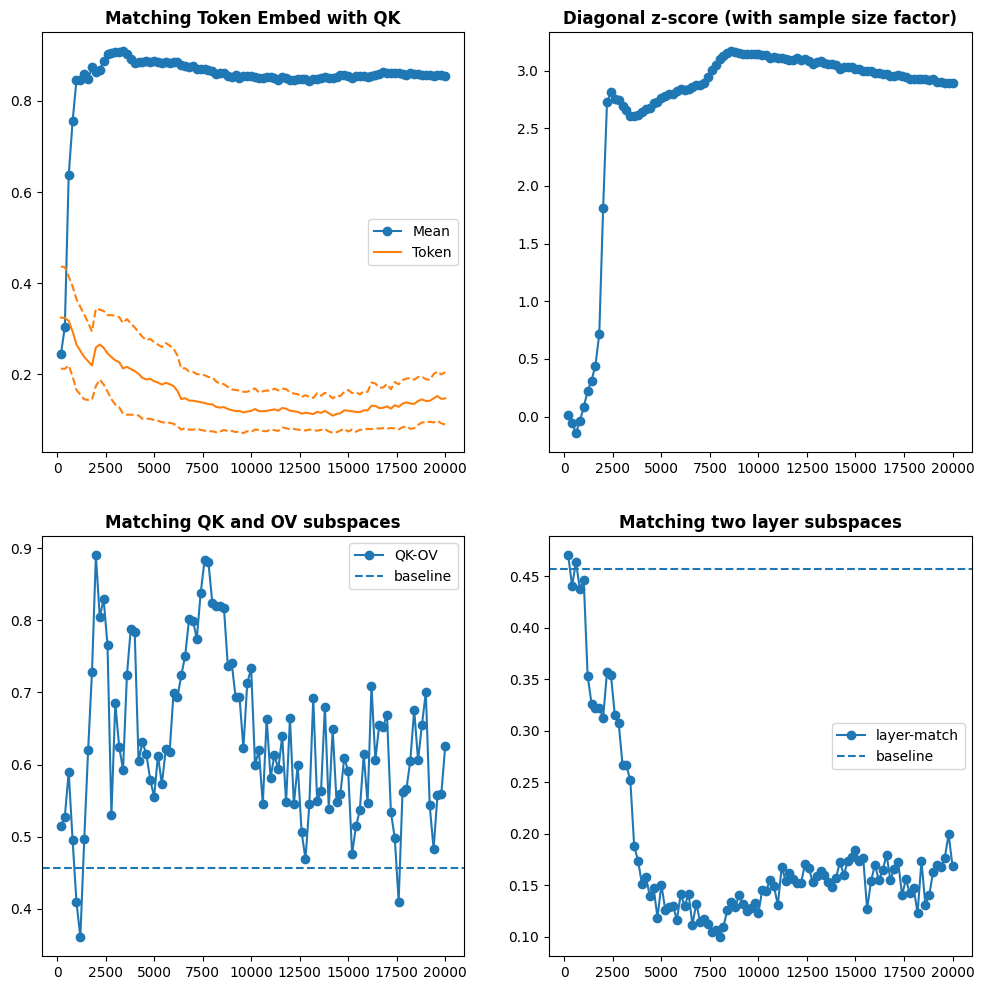

In [11]:
ranks = [5, 10, 15, 20]
analysis_dir = "Figs_analysis"
rank_idx = 0

ratios = np.zeros((100, 3))
z_scores = np.zeros(100)
s_matches = np.zeros((100, 2))
match_layer = np.zeros((100, 4))

s_base = match_baseline(config.d_model, ranks[0], num_run=100)

for i, iter in enumerate(range(200, 20200, 200)):
    model = TFModel(config)
    ckpt_path = os.path.join("out_phase_progress_long", setting_dir, f"ckpt_{iter}.pt")
    model.load_state_dict(torch.load(ckpt_path, map_location=torch.device("cpu")))
    model.eval()

    coeffs, svals2 = position_matching(model, config, ranks=ranks)
    QK0, QK_all, z_score, s_match = token_matching(model, config, ranks=ranks)
    layer_scores = match_between_layer(model, config, ranks=ranks)
    ratios[i, :2] = np.mean(coeffs[rank_idx, :-1, 0]), np.std(coeffs[rank_idx, :-1, 0])
    ratios[i, 2] = coeffs[rank_idx, -1, 0]
    z_scores[i] = z_score
    s_matches[i] = s_match[rank_idx, 0], s_match[rank_idx, 1]  # for now, fix rank = 5
    match_layer[i] = layer_scores[rank_idx]


from utils import create_folder

create_folder(analysis_dir)
match_method = "largest"  # 'largest' | 'mean'
k = 0 if match_method == "largest" else 1
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]  # default colors

xrange = range(200, 20200, 200)
fig, axs = plt.subplots(2, 2, figsize=(6 * 2, 6 * 2))
axs[0, 0].plot(xrange, ratios[:, 2], "-o", color=colors[0], label="Mean")
axs[0, 0].plot(xrange, ratios[:, 0], "-", color=colors[1], label="Token")
axs[0, 0].plot(xrange, ratios[:, 0] + ratios[:, 1], "--", color=colors[1])
axs[0, 0].plot(xrange, ratios[:, 0] - ratios[:, 1], "--", color=colors[1])
axs[0, 0].legend()
axs[0, 0].set_title("Matching Token Embed with QK", weight="bold")
axs[0, 1].plot(xrange, z_scores, "-o")
axs[0, 1].set_title("Diagonal z-score (with sample size factor)", weight="bold")
axs[1, 0].plot(xrange, s_matches[:, k], "-o", label="QK-OV")
axs[1, 0].axhline(y=s_base[k], linestyle="--", label="baseline")
axs[1, 0].set_title("Matching QK and OV subspaces", weight="bold")
axs[1, 0].legend()
axs[1, 1].plot(xrange, match_layer[:, k + 2], "-o", label="layer-match")
axs[1, 1].axhline(y=s_base[k], linestyle="--", label="baseline")
axs[1, 1].set_title("Matching two layer subspaces", weight="bold")
axs[1, 1].legend()
plt.savefig(
    os.path.join(analysis_dir, f"train_matching_measure_{setting_dir}"),
    bbox_inches="tight",
)

# Large Pool Size (=1000)

In [12]:
setting_dir = "large_pool_size"

with open(
    os.path.join("out_phase_progress_long", setting_dir, "config.json"), "r"
) as f:
    config = Config(**json.load(f))

model = TFModel(config).to(config.device)

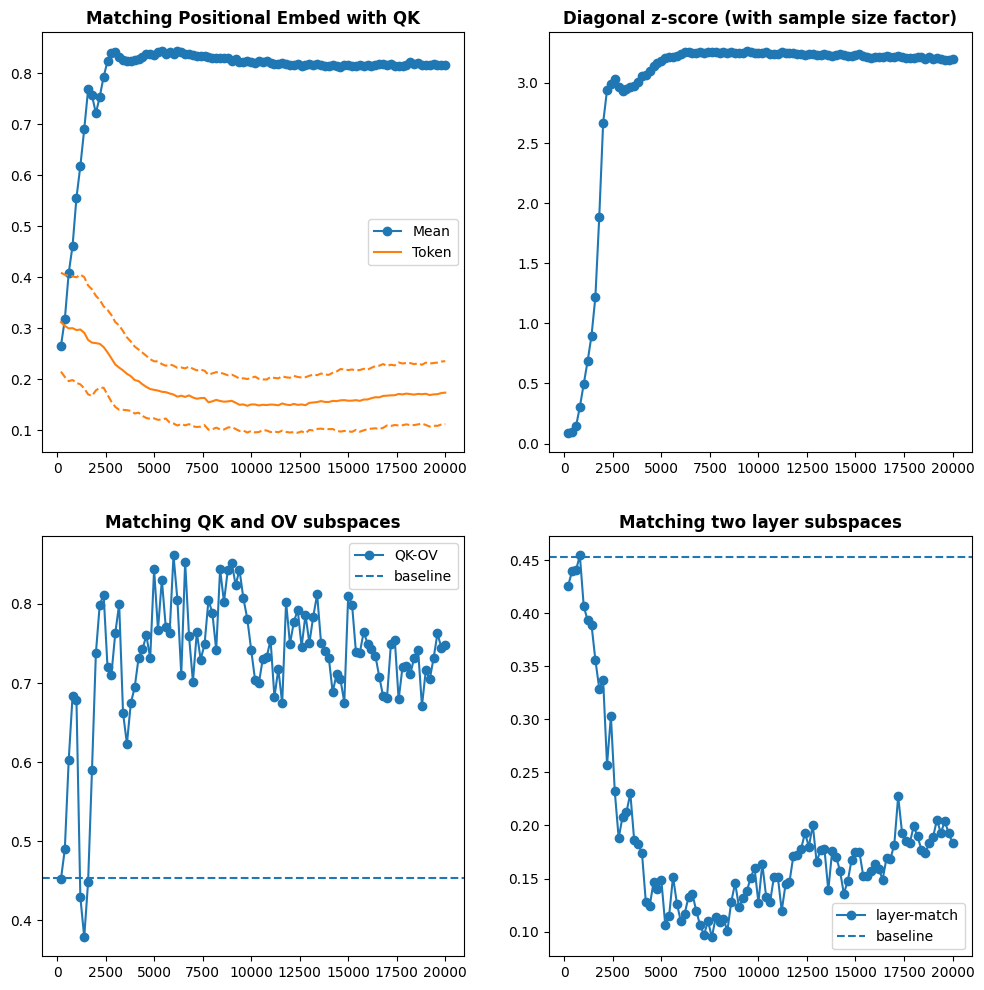

In [13]:
ranks = [5, 10, 15, 20]
analysis_dir = "Figs_analysis"
rank_idx = 0

ratios = np.zeros((100, 3))
z_scores = np.zeros(100)
s_matches = np.zeros((100, 2))
match_layer = np.zeros((100, 4))

s_base = match_baseline(config.d_model, ranks[0], num_run=100)

for i, iter in enumerate(range(200, 20200, 200)):
    model = TFModel(config)
    ckpt_path = os.path.join("out_phase_progress_long", setting_dir, f"ckpt_{iter}.pt")
    model.load_state_dict(torch.load(ckpt_path, map_location=torch.device("cpu")))
    model.eval()

    coeffs, svals2 = position_matching(model, config, ranks=ranks)
    QK0, QK_all, z_score, s_match = token_matching(model, config, ranks=ranks)
    layer_scores = match_between_layer(model, config, ranks=ranks)
    ratios[i, :2] = np.mean(coeffs[rank_idx, :-1, 0]), np.std(coeffs[rank_idx, :-1, 0])
    ratios[i, 2] = coeffs[rank_idx, -1, 0]
    z_scores[i] = z_score
    s_matches[i] = s_match[rank_idx, 0], s_match[rank_idx, 1]  # for now, fix rank = 5
    match_layer[i] = layer_scores[rank_idx]


from utils import create_folder

create_folder(analysis_dir)
match_method = "largest"  # 'largest' | 'mean'
k = 0 if match_method == "largest" else 1
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]  # default colors

xrange = range(200, 20200, 200)
fig, axs = plt.subplots(2, 2, figsize=(6 * 2, 6 * 2))
axs[0, 0].plot(xrange, ratios[:, 2], "-o", color=colors[0], label="Mean")
axs[0, 0].plot(xrange, ratios[:, 0], "-", color=colors[1], label="Token")
axs[0, 0].plot(xrange, ratios[:, 0] + ratios[:, 1], "--", color=colors[1])
axs[0, 0].plot(xrange, ratios[:, 0] - ratios[:, 1], "--", color=colors[1])
axs[0, 0].legend()
axs[0, 0].set_title("Matching Positional Embed with QK", weight="bold")
axs[0, 1].plot(xrange, z_scores, "-o")
axs[0, 1].set_title("Diagonal z-score (with sample size factor)", weight="bold")
axs[1, 0].plot(xrange, s_matches[:, k], "-o", label="QK-OV")
axs[1, 0].axhline(y=s_base[k], linestyle="--", label="baseline")
axs[1, 0].set_title("Matching QK and OV subspaces", weight="bold")
axs[1, 0].legend()
axs[1, 1].plot(xrange, match_layer[:, k + 2], "-o", label="layer-match")
axs[1, 1].axhline(y=s_base[k], linestyle="--", label="baseline")
axs[1, 1].set_title("Matching two layer subspaces", weight="bold")
axs[1, 1].legend()
plt.savefig(
    os.path.join(analysis_dir, f"train_matching_measure_{setting_dir}"),
    bbox_inches="tight",
)

# Small Pool Size (=100)

In [14]:
setting_dir = "small_pool_size"

with open(
    os.path.join("out_phase_progress_long", setting_dir, "config.json"), "r"
) as f:
    config = Config(**json.load(f))

model = TFModel(config).to(config.device)

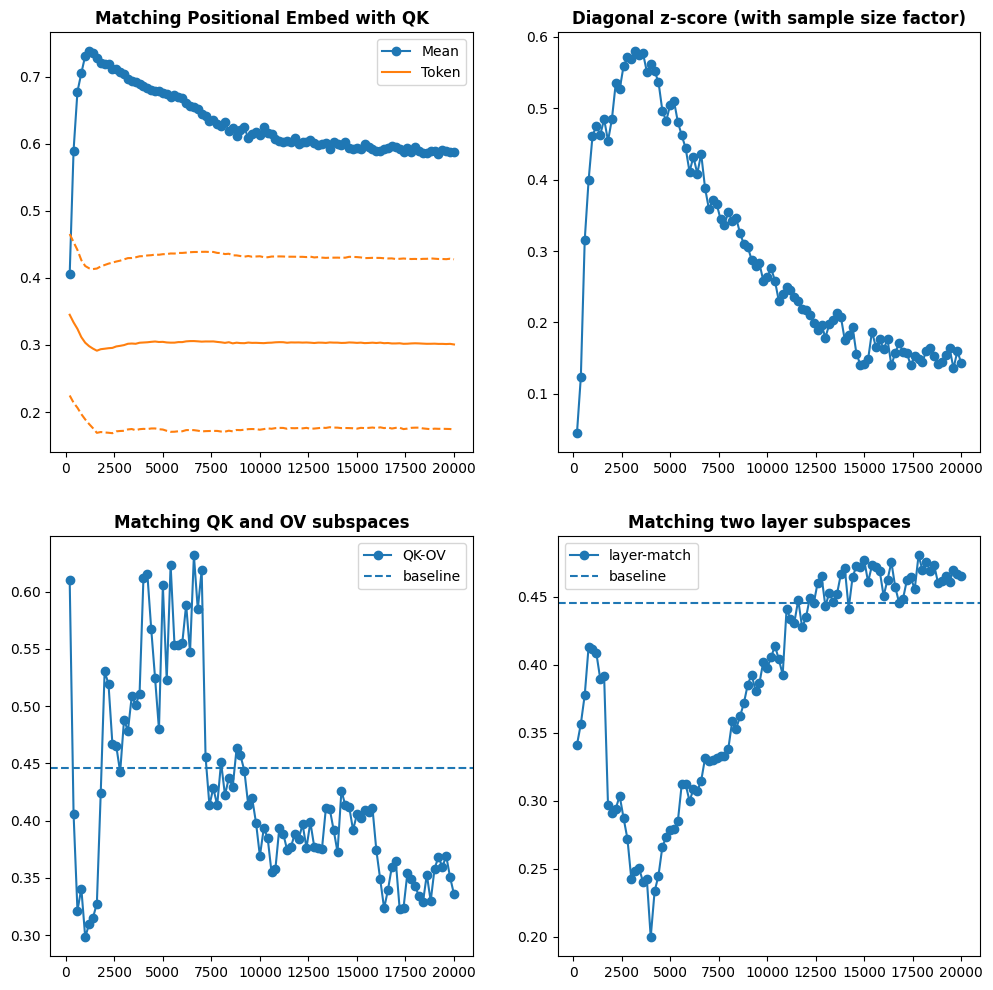

In [15]:
ranks = [5, 10, 15, 20]
analysis_dir = "Figs_analysis"
rank_idx = 0

ratios = np.zeros((100, 3))
z_scores = np.zeros(100)
s_matches = np.zeros((100, 2))
match_layer = np.zeros((100, 4))

s_base = match_baseline(config.d_model, ranks[0], num_run=100)

for i, iter in enumerate(range(200, 20200, 200)):
    model = TFModel(config)
    ckpt_path = os.path.join("out_phase_progress_long", setting_dir, f"ckpt_{iter}.pt")
    model.load_state_dict(torch.load(ckpt_path, map_location=torch.device("cpu")))
    model.eval()

    coeffs, svals2 = position_matching(model, config, ranks=ranks)
    QK0, QK_all, z_score, s_match = token_matching(model, config, ranks=ranks)
    layer_scores = match_between_layer(model, config, ranks=ranks)
    ratios[i, :2] = np.mean(coeffs[rank_idx, :-1, 0]), np.std(coeffs[rank_idx, :-1, 0])
    ratios[i, 2] = coeffs[rank_idx, -1, 0]
    z_scores[i] = z_score
    s_matches[i] = s_match[rank_idx, 0], s_match[rank_idx, 1]  # for now, fix rank = 5
    match_layer[i] = layer_scores[rank_idx]


from utils import create_folder

create_folder(analysis_dir)
match_method = "largest"  # 'largest' | 'mean'
k = 0 if match_method == "largest" else 1
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]  # default colors

xrange = range(200, 20200, 200)
fig, axs = plt.subplots(2, 2, figsize=(6 * 2, 6 * 2))
axs[0, 0].plot(xrange, ratios[:, 2], "-o", color=colors[0], label="Mean")
axs[0, 0].plot(xrange, ratios[:, 0], "-", color=colors[1], label="Token")
axs[0, 0].plot(xrange, ratios[:, 0] + ratios[:, 1], "--", color=colors[1])
axs[0, 0].plot(xrange, ratios[:, 0] - ratios[:, 1], "--", color=colors[1])
axs[0, 0].legend()
axs[0, 0].set_title("Matching Positional Embed with QK", weight="bold")
axs[0, 1].plot(xrange, z_scores, "-o")
axs[0, 1].set_title("Diagonal z-score (with sample size factor)", weight="bold")
axs[1, 0].plot(xrange, s_matches[:, k], "-o", label="QK-OV")
axs[1, 0].axhline(y=s_base[k], linestyle="--", label="baseline")
axs[1, 0].set_title("Matching QK and OV subspaces", weight="bold")
axs[1, 0].legend()
axs[1, 1].plot(xrange, match_layer[:, k + 2], "-o", label="layer-match")
axs[1, 1].axhline(y=s_base[k], linestyle="--", label="baseline")
axs[1, 1].set_title("Matching two layer subspaces", weight="bold")
axs[1, 1].legend()
plt.savefig(
    os.path.join(analysis_dir, f"train_matching_measure_{setting_dir}"),
    bbox_inches="tight",
)

# Boundary Pool Size (=740)

In [16]:
setting_dir = "boundary_pool_size_740"

with open(
    os.path.join("out_phase_progress_long", setting_dir, "config.json"), "r"
) as f:
    config = Config(**json.load(f))

model = TFModel(config).to(config.device)

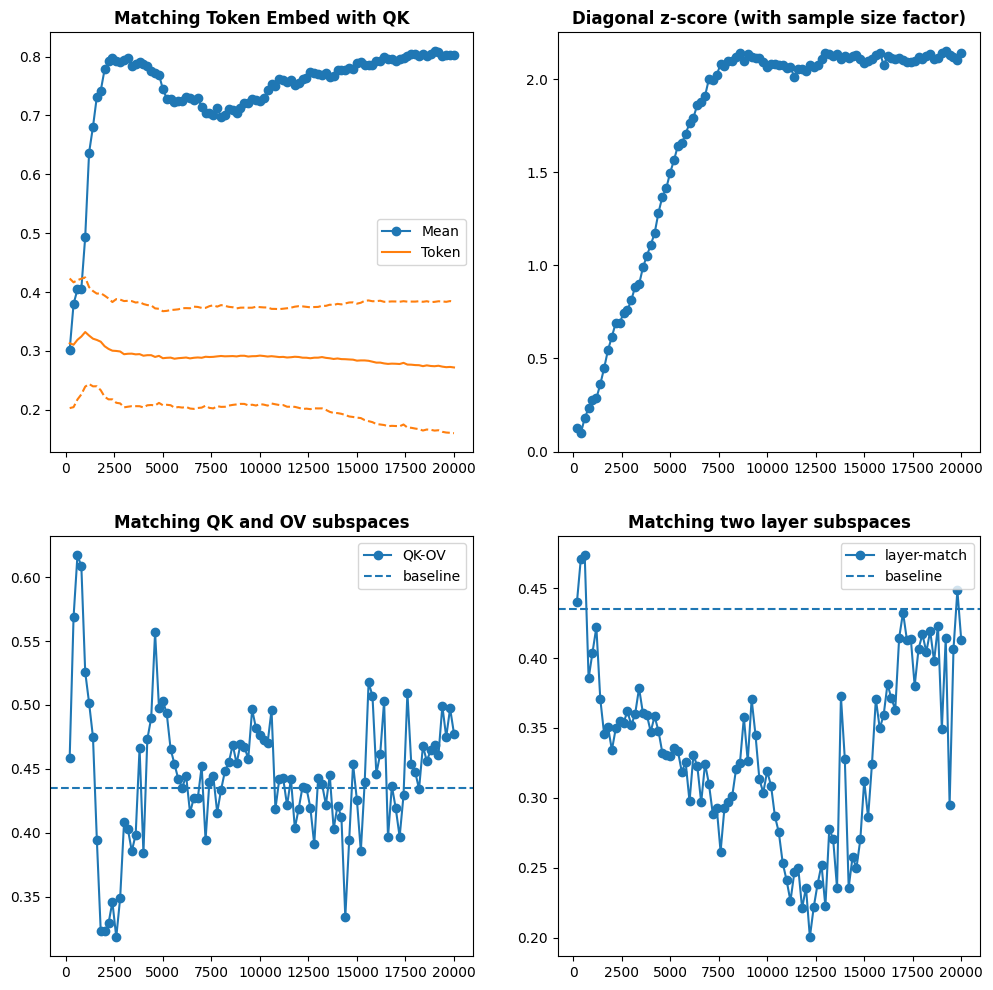

In [18]:
ranks = [5, 10, 15, 20]
analysis_dir = "Figs_analysis"
rank_idx = 0

ratios = np.zeros((100, 3))
z_scores = np.zeros(100)
s_matches = np.zeros((100, 2))
match_layer = np.zeros((100, 4))

s_base = match_baseline(config.d_model, ranks[0], num_run=100)

for i, iter in enumerate(range(200, 20200, 200)):
    model = TFModel(config)
    ckpt_path = os.path.join("out_phase_progress_long", setting_dir, f"ckpt_{iter}.pt")
    model.load_state_dict(torch.load(ckpt_path, map_location=torch.device("cpu")))
    model.eval()

    coeffs, svals2 = position_matching(model, config, ranks=ranks)
    QK0, QK_all, z_score, s_match = token_matching(model, config, ranks=ranks)
    layer_scores = match_between_layer(model, config, ranks=ranks)
    ratios[i, :2] = np.mean(coeffs[rank_idx, :-1, 0]), np.std(coeffs[rank_idx, :-1, 0])
    ratios[i, 2] = coeffs[rank_idx, -1, 0]
    z_scores[i] = z_score
    s_matches[i] = s_match[rank_idx, 0], s_match[rank_idx, 1]  # for now, fix rank = 5
    match_layer[i] = layer_scores[rank_idx]


from utils import create_folder

create_folder(analysis_dir)
match_method = "largest"  # 'largest' | 'mean'
k = 0 if match_method == "largest" else 1
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]  # default colors

xrange = range(200, 20200, 200)
fig, axs = plt.subplots(2, 2, figsize=(6 * 2, 6 * 2))
axs[0, 0].plot(xrange, ratios[:, 2], "-o", color=colors[0], label="Mean")
axs[0, 0].plot(xrange, ratios[:, 0], "-", color=colors[1], label="Token")
axs[0, 0].plot(xrange, ratios[:, 0] + ratios[:, 1], "--", color=colors[1])
axs[0, 0].plot(xrange, ratios[:, 0] - ratios[:, 1], "--", color=colors[1])
axs[0, 0].legend()
axs[0, 0].set_title("Matching Token Embed with QK", weight="bold")
axs[0, 1].plot(xrange, z_scores, "-o")
axs[0, 1].set_title("Diagonal z-score (with sample size factor)", weight="bold")
axs[1, 0].plot(xrange, s_matches[:, k], "-o", label="QK-OV")
axs[1, 0].axhline(y=s_base[k], linestyle="--", label="baseline")
axs[1, 0].set_title("Matching QK and OV subspaces", weight="bold")
axs[1, 0].legend()
axs[1, 1].plot(xrange, match_layer[:, k + 2], "-o", label="layer-match")
axs[1, 1].axhline(y=s_base[k], linestyle="--", label="baseline")
axs[1, 1].set_title("Matching two layer subspaces", weight="bold")
axs[1, 1].legend()
plt.savefig(
    os.path.join(analysis_dir, f"train_matching_measure_{setting_dir}"),
    bbox_inches="tight",
)

# Boundary Pool Size (=750)

In [19]:
setting_dir = "boundary_pool_size_750"

with open(
    os.path.join("out_phase_progress_long", setting_dir, "config.json"), "r"
) as f:
    config = Config(**json.load(f))

model = TFModel(config).to(config.device)

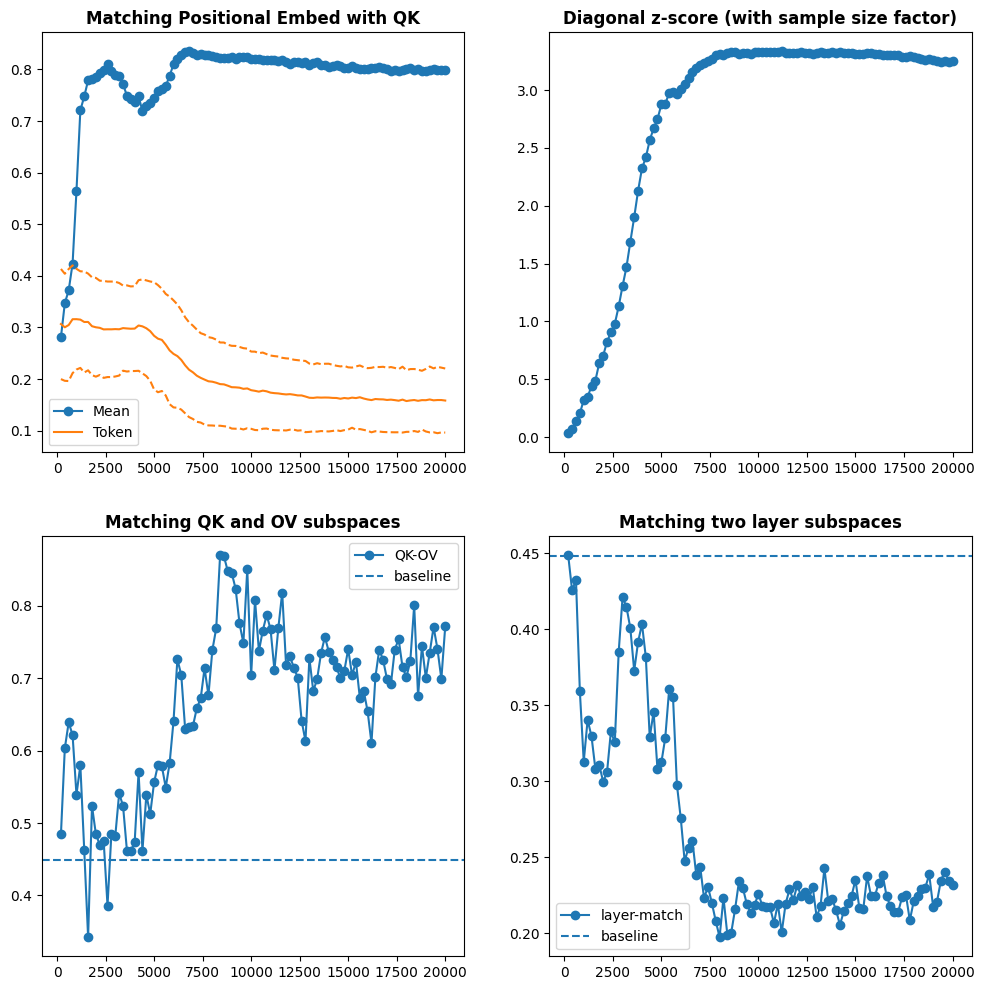

In [20]:
ranks = [5, 10, 15, 20]
analysis_dir = "Figs_analysis"
rank_idx = 0

ratios = np.zeros((100, 3))
z_scores = np.zeros(100)
s_matches = np.zeros((100, 2))
match_layer = np.zeros((100, 4))

s_base = match_baseline(config.d_model, ranks[0], num_run=100)

for i, iter in enumerate(range(200, 20200, 200)):
    model = TFModel(config)
    ckpt_path = os.path.join("out_phase_progress_long", setting_dir, f"ckpt_{iter}.pt")
    model.load_state_dict(torch.load(ckpt_path, map_location=torch.device("cpu")))
    model.eval()

    coeffs, svals2 = position_matching(model, config, ranks=ranks)
    QK0, QK_all, z_score, s_match = token_matching(model, config, ranks=ranks)
    layer_scores = match_between_layer(model, config, ranks=ranks)
    ratios[i, :2] = np.mean(coeffs[rank_idx, :-1, 0]), np.std(coeffs[rank_idx, :-1, 0])
    ratios[i, 2] = coeffs[rank_idx, -1, 0]
    z_scores[i] = z_score
    s_matches[i] = s_match[rank_idx, 0], s_match[rank_idx, 1]  # for now, fix rank = 5
    match_layer[i] = layer_scores[rank_idx]


from utils import create_folder

create_folder(analysis_dir)
match_method = "largest"  # 'largest' | 'mean'
k = 0 if match_method == "largest" else 1
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]  # default colors

xrange = range(200, 20200, 200)
fig, axs = plt.subplots(2, 2, figsize=(6 * 2, 6 * 2))
axs[0, 0].plot(xrange, ratios[:, 2], "-o", color=colors[0], label="Mean")
axs[0, 0].plot(xrange, ratios[:, 0], "-", color=colors[1], label="Token")
axs[0, 0].plot(xrange, ratios[:, 0] + ratios[:, 1], "--", color=colors[1])
axs[0, 0].plot(xrange, ratios[:, 0] - ratios[:, 1], "--", color=colors[1])
axs[0, 0].legend()
axs[0, 0].set_title("Matching Positional Embed with QK", weight="bold")
axs[0, 1].plot(xrange, z_scores, "-o")
axs[0, 1].set_title("Diagonal z-score (with sample size factor)", weight="bold")
axs[1, 0].plot(xrange, s_matches[:, k], "-o", label="QK-OV")
axs[1, 0].axhline(y=s_base[k], linestyle="--", label="baseline")
axs[1, 0].set_title("Matching QK and OV subspaces", weight="bold")
axs[1, 0].legend()
axs[1, 1].plot(xrange, match_layer[:, k + 2], "-o", label="layer-match")
axs[1, 1].axhline(y=s_base[k], linestyle="--", label="baseline")
axs[1, 1].set_title("Matching two layer subspaces", weight="bold")
axs[1, 1].legend()
plt.savefig(
    os.path.join(analysis_dir, f"train_matching_measure_{setting_dir}"),
    bbox_inches="tight",
)